### Import Packages 

In [1]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 
import cmocean as cm

# cartopy 
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cartopy.feature as cfeature

### Step 1. Set up Dask for lazy/parallel computing 

In [5]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster(worker_memory=8)  # specify worker memory, max = 8
cluster.adapt(minimum=1, maximum=60)  # specify how many workers 
client = Client(cluster)
cluster

click on the above link to access the Dask dashboard

### Step 2. Load the MUR SST Dataset

2.1 Load the MUR SST dataset from AWS 

2.2 Mask out erroneous data near poles 

In [7]:
# 2.1 load MUR SST dataset from AWS
%time 
AWS_url = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1'
ds_sst = xr.open_zarr(AWS_url, consolidated=True)
ds_sst

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Note that the MUR SST dataset from AWS only has data available from 2002-Jan 2020, where as the dataset from PODAAC has data availble to present day (Nov. 2021). 

##### There are some erroneous SSTs near land at the poles so we will mask those out based on sea-ice fraction 

In [8]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction)) 
 

sst_masked = ds_sst['analysed_sst'].where(cond)

sst_masked

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,1276113 Tasks,141790 Chunks
Type,float32,numpy.ndarray


### Step 3. Create daily, monthly, yearly, and seasonal climatologies and anomalies 

#### let's create daily, monthly, yearly, and seasonal climatologies and anomalies 

In [9]:
%%time
#create a daily climatology and anomaly
daily_clima = sst_masked.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

daily_anom = sst_masked.groupby('time.dayofyear')-daily_clima  #take out annual mean to remove trends

#create a monthly dataset, climatology, and anomaly
sst_monthly = sst_masked.resample(time='1MS').mean('time',keep_attrs=True,skipna=False)

monthly_clima = sst_monthly.groupby('time.month').mean('time',keep_attrs=True,skipna=False)

monthly_anom = sst_monthly.groupby('time.month')-monthly_clima  #take out annual mean to remove trends

# create a yearly dataset, climatology, and anomaly 

sst_yearly = sst_masked.resample(time='1Y').mean('time',keep_attrs=True,skipna=False)

yearly_clima = sst_yearly.groupby('time.year').mean('time',keep_attrs=True,skipna=False)

yearly_anom = sst_yearly.groupby('time.year')-yearly_clima


CPU times: user 14.2 s, sys: 490 ms, total: 14.7 s
Wall time: 14.7 s


In [10]:
sst_seasonal = sst_monthly.resample(time='3M').mean()

In [11]:
JJA = sst_seasonal[0::4]
SON = sst_seasonal[1::4]
DJF = sst_seasonal[2::4]
MAM = sst_seasonal[3::4]

In [12]:
# calculate seasonal climas and anoms 

# JJA_clima = JJA.mean(dim='time')
# JJA_anom = JJA - JJA_clima 

# SON_clima = SON.mean(dim='time')
# SON_anom = SON - SON_clima 

# DJF_clima = DJF.mean(dim='time')
# DJF_anom = DJF - DJF_clima 

# MAM_clima = MAM.mean(dim='time')
# MAM_anom = MAM - MAM_clima 

seasons=['JJA','SON','DJF','MAM']
for season in seasons:
    exec(season+ '_clima = '+season+'.mean(dim="time")')
    exec(season+ '_anom = '+season + '-' + season + '_clima')

### Make global plots using xarray coarsen 

In [13]:
summerday = sst_masked.sel(time='2019-07-30')

In [14]:
summerday

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
dask.array<getitem, shape=(1, 17999, 36000), dtype=float32, chunksize=(1, 1799, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-07-30T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [15]:
summerday = summerday.coarsen(lat=10,lon=10,boundary='trim').mean()

In [16]:
summerday

<xarray.DataArray (time: 1, lat: 1799, lon: 3600)>
dask.array<mean_agg-aggregate, shape=(1, 1799, 3600), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.95 -89.84 -89.75 -89.64 ... 89.66 89.75 89.86
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 2019-07-30T09:00:00

In [17]:
summerday = summerday - 273.15

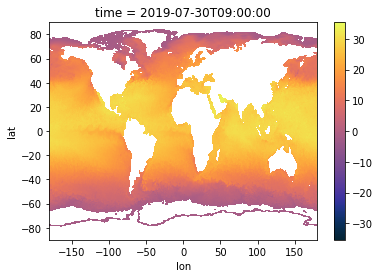

In [19]:
summerday.plot(cmap='cmo.thermal')

### Step 4: Slice the dataset for desired regions (ATOMIC and LIS)

#### Let's slice the datasets for ATOMIC sampling area
##### Overall question: Has SST changed historically in the ATOMIC area. If so, how?

In [21]:
daily_sst = sst_masked.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_clima = daily_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_anom = daily_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_sst = sst_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_clima = monthly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_anom = monthly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_sst = sst_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_clima = yearly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_anom = yearly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

JJA = JJA.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_clima = JJA_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_anom = JJA_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
SON = SON.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_clima = SON_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_anom = SON_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF = DJF.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_clima = DJF_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_anom = DJF_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM = MAM.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_clima = MAM_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_anom = MAM_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

#### spatially average ATOMIC area and look at trends 

In [22]:
daily_spatial = daily_sst.mean(dim=('lon','lat')).load()
monthly_spatial = monthly_sst.mean(dim=('lon','lat')).load()
yearly_spatial = yearly_sst.mean(dim=('lon','lat')).load()

In [23]:
daily_spatial = daily_spatial - 273.15
monthly_spatial = monthly_spatial - 273.15
yearly_spatial = yearly_spatial - 273.15

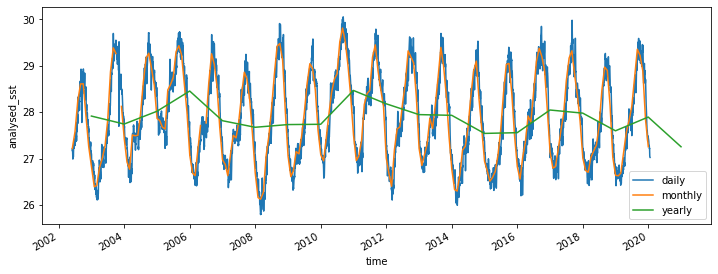

In [24]:
fig = plt.figure(figsize=(12,4))
daily_spatial.plot(label='daily')
monthly_spatial.plot(label='monthly')
yearly_spatial.plot(label='yearly')
plt.legend()

In [25]:
seasons = ['JJA','DJF','MAM','SON']
for season in seasons:
    exec(season+'.load()')
    exec(season +'='+season+'-273.15')

In [26]:
seasons = ['JJA','DJF','MAM','SON']
for season in seasons:
    exec(season+'_clima.load()')
    exec(season +'_clima ='+season+'_clima -273.15')

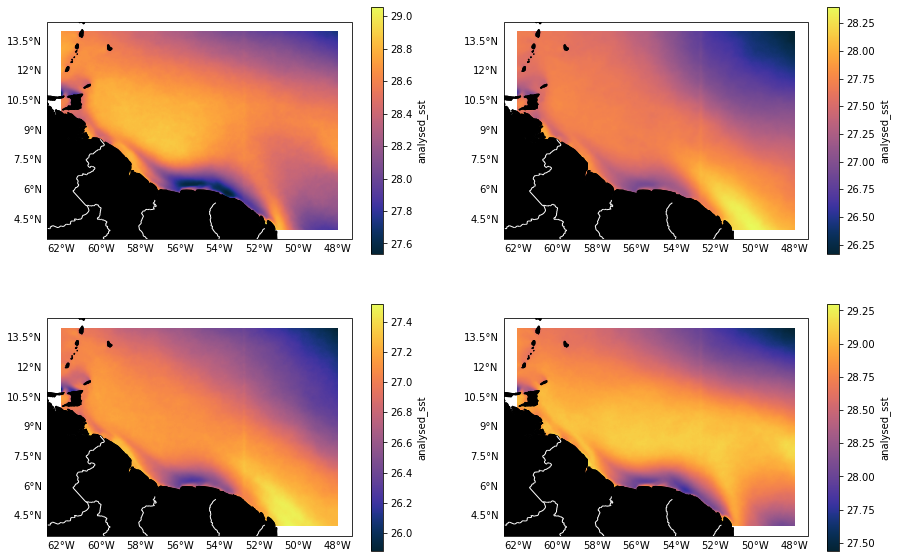

In [27]:
# Seasonal plots using cartopy 

kw = {'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

DJF_clima.plot(ax=axs[0],**kw,zorder=0)
JJA_clima.plot(ax=axs[1],**kw,zorder=0)
MAM_clima.plot(ax=axs[2],**kw,zorder=0)
SON_clima.plot(ax=axs[3],**kw,zorder=0)

for i in [0,1,2,3]:
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
#     axs[i].add_feature(cartopy.feature.RIVERS,zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

In [28]:
JJA_spatial = JJA.mean(dim=('lat','lon'))
SON_spatial = SON.mean(dim=('lat','lon'))
DJF_spatial = DJF.mean(dim=('lat','lon'))
MAM_spatial = MAM.mean(dim=('lat','lon'))

In [29]:
SON_spatial.load()
MAM_spatial.load()
DJF_spatial.load()
JJA_spatial.load()

<xarray.DataArray 'analysed_sst' (time: 18)>
array([27.21515 , 27.026215, 27.499182, 28.237371, 27.469313, 27.349003,
       26.93742 , 27.242039, 28.358978, 27.984653, 27.502687, 27.610497,
       27.033056, 26.804169, 27.689322, 27.580812, 27.155437, 27.50962 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-30 2003-06-30 ... 2019-06-30

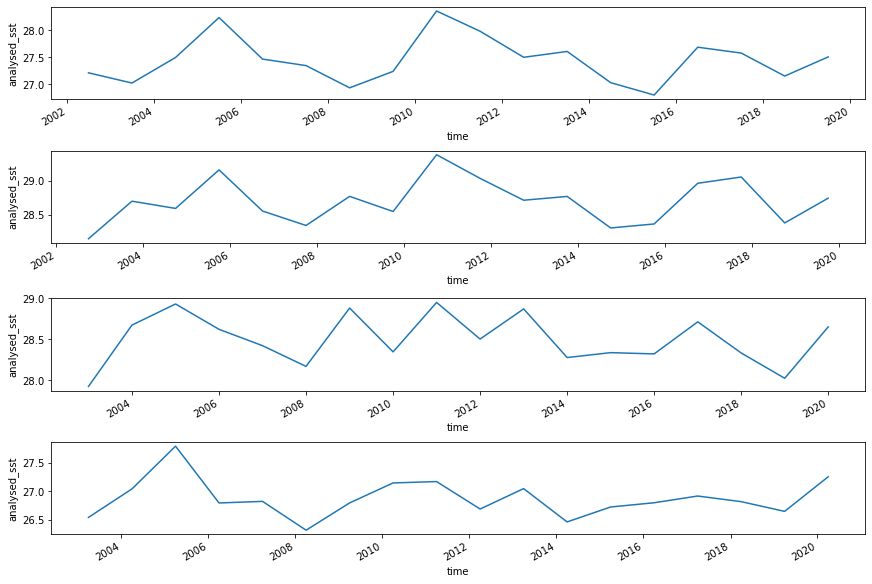

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=4, constrained_layout=True, figsize=(12,8))
JJA_spatial.plot(label='JJA',ax=ax[0])
SON_spatial.plot(label='SON',ax=ax[1])
DJF_spatial.plot(label='DJF',ax=ax[2])
MAM_spatial.plot(label='MAM',ax=ax[3])

### Stats

In [31]:
def get_stats(X):
    return [np.round(np.mean(X).values,2),np.round(np.min(X).values,2),np.round(np.max(X).values,2)]

In [32]:
JJA_spatial_stats = get_stats(JJA_spatial)
SON_spatial_stats = get_stats(SON_spatial)
MAM_spatial_stats = get_stats(MAM_spatial)
DJF_spatial_stats = get_stats(DJF_spatial)
yearly_spatial_stats = get_stats(yearly_spatial)

In [33]:
time_range=['JJA','SON','DJF','MAM','yearly']
for time in time_range:
    exec(time+'_dates = [str('+time+'_spatial[np.argmin('+time+'_spatial.values)].time.values)[:4],'
             'str('+time+'_spatial[np.argmax('+time+'_spatial.values)].time.values)[:4]]')

In [34]:
means = [DJF_spatial_stats[0],MAM_spatial_stats[0],JJA_spatial_stats[0],SON_spatial_stats[0],
        yearly_spatial_stats[0]]
mins = [DJF_spatial_stats[1],MAM_spatial_stats[1],JJA_spatial_stats[1],SON_spatial_stats[1],
       yearly_spatial_stats[1]]
min_year = [DJF_dates[0],MAM_dates[0],JJA_dates[0],SON_dates[0],
       yearly_dates[0]]
max_year = [DJF_dates[1],MAM_dates[1],JJA_dates[1],SON_dates[1],
       yearly_dates[1]]
maxs = [DJF_spatial_stats[2],MAM_spatial_stats[2],JJA_spatial_stats[2],SON_spatial_stats[2],
       yearly_spatial_stats[2]]
times = ['DJF','MAM','JJA','SON','Year']

In [35]:
df = pd.DataFrame(data=([times,means,mins,min_year,maxs,max_year]))
df = df.T
df = df.rename(columns={0:'Time Frame',1:'SST Mean',2:'SST Min',3:'Min Year',
                        4:'SST Max',5:'Max Year'})
df

,Time Frame,SST Mean,SST Min,Min Year,SST Max,Max Year
0,DJF,28.5,27.92,2002,28.95,2010
1,MAM,26.879999,26.32,2008,27.79,2005
2,JJA,27.459999,26.8,2015,28.36,2010
3,SON,28.690001,28.14,2002,29.39,2010
4,Year,27.870001,27.25,2020,28.47,2010
